## 05_02: Time profiling

For further profiling information look at:   
https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [67]:
import numpy as np

import matplotlib
import matplotlib.pyplot as pp

In [68]:
def run_mandel(extent=(-2.0,1.0,-1.5,1.5), res=256, maxit=256):
    xs = np.linspace(extent[0], extent[1], res)  # x and y arrays,
    ys = np.linspace(extent[2], extent[3], res)  # equally spaced
    
    escaped = np.zeros((res,res), np.float64)  # escape status of points
    
    # loop over region in complex plane
    for i in range(res):
        for j in range(res):
            c = xs[i] + 1j * ys[j]  # build complex number
            escaped[i,j] = compute_mandel(c, maxit)  # call iteration
    
    return escaped / maxit  # normalize for better plotting

In [69]:
def compute_mandel(c, maxit=256):
    z = 0.0j

    for it in range(1, maxit):
        z = z*z + c
        
        if abs(z) > 2.0:
            return it

    # if we have not escaped in maxit iterations, assume we'll never do
    return np.inf

In [70]:
def plot_mandel(array):
    pp.figure(figsize=(6,6))

    cmap = matplotlib.cm.get_cmap("coolwarm").copy()
    cmap.set_bad('k')

    pp.imshow(array.T, cmap=cmap, norm=matplotlib.colors.PowerNorm(0.6), 
              interpolation='none', origin='lower')

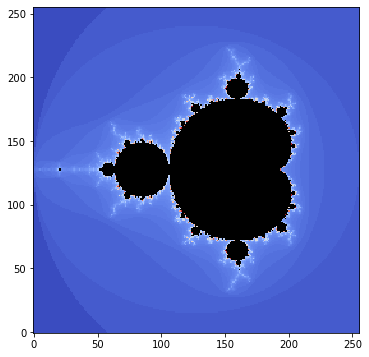

In [71]:
plot_mandel(run_mandel())

In [72]:
%timeit run_mandel()

429 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%prun -s cumulative run_mandel()

In [51]:
%prun?

In [52]:
# requires:
# $ pip install line_profiler
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [53]:
%lprun -f compute_mandel run_mandel()

In [54]:
def run_mandel_numpy(extent=(-2.0,1.0,-1.5,1.5), res=256, maxit=256):
    # as before
    xs = np.linspace(extent[0], extent[1], res)
    ys = np.linspace(extent[2], extent[3], res)
    
    # escape status of points; start them out at infinity
    escaped = np.full((res,res), np.inf, np.float64)
    
    # prepare complex values across array
    c = xs[:,np.newaxis] + 1j*ys[np.newaxis,:]
    z = np.zeros_like(c, 'complex128')
    
    for it in range(1, maxit):
        # the Mandelbrot formula!
        z = z*z + c
        
        # save iteration number for newly escaped points
        escaped[(escaped == np.inf) & (np.abs(z) > 2.0)] = it
    
    return escaped / maxit

In [55]:
np.seterr(over='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

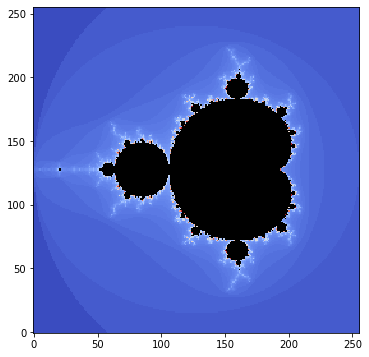

In [56]:
plot_mandel(run_mandel_numpy())

In [57]:
%timeit run_mandel_numpy()

86.1 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%lprun -f run_mandel_numpy run_mandel_numpy()

In [59]:
from numba.core.decorators import jit

In [73]:
@jit
def run_mandel_numba(extent=(-2.0,1.0,-1.5,1.5), res=256, maxit=256):
    xs = np.linspace(extent[0], extent[1], res)
    ys = np.linspace(extent[2], extent[3], res)
    
    escaped = np.zeros((res,res), np.float64)
    
    for i in range(res):
        for j in range(res):
            c = xs[i] + 1j * ys[j]
            escaped[i,j] = compute_mandel_numba(c, maxit)
    
    return escaped / maxit

@jit
def compute_mandel_numba(c, maxit=256):
    z = 0.0j

    for it in range(1, maxit):
        z = z*z + c
        
        if abs(z) > 2.0:
            return it

    return np.inf

In [74]:
%timeit run_mandel_numba()

11 ms ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
import ipywidgets

In [76]:
def plot_zoomed(zoom):
    pp.figure(figsize=(6,6))
    
    cmap = matplotlib.cm.coolwarm
    cmap.set_bad('k')
    
    # center the zoom at an interesting point;
    # increase iterations and resolutions to see better
    array = run_mandel_numba(extent=(-0.75 - 1.5/zoom, -0.75 + 1.5/zoom, 0.1 - 1.5/zoom, 0.1 + 1.5/zoom),
                             maxit=512, res=512)
    
    pp.imshow(array.T, cmap=cmap, norm=matplotlib.colors.PowerNorm(0.6), 
              interpolation='none', origin='lower')

In [77]:
ipywidgets.interact(plot_zoomed,
                    zoom=ipywidgets.FloatSlider(min=1, max=200, step=0.05, value=1, continuous_update=False))

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='zoom', max=200.0, min=1.0, …

<function __main__.plot_zoomed(zoom)>